In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from matplotlib import pylab as plt

# the following commands make plots look better
plt.rc('font', size=12)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [2., 2.])

In [29]:
results_df = pd.read_csv('./data/election_results_presidential.csv')
polls_df = pd.read_csv('./data/pres_pollaverages_1968-2016.csv')

In [38]:
# Function to filter polls by the latest modeldate for each cycle
def filter_latest_polls(df):
    # Convert modeldate to datetime
    df['modeldate'] = pd.to_datetime(df['modeldate'])
    
    # Sort by cycle and modeldate
    df = df.sort_values(['cycle', 'modeldate'])
    
    # Get the latest poll for each cycle
    latest_polls = df.groupby('cycle')['modeldate'].transform('max')
    df_filtered = df[df['modeldate'] == latest_polls]
    
    return df_filtered

In [39]:
polls_df[polls_df['cycle']==2016]['modeldate'].unique()

<DatetimeArray>
['2016-11-08 00:00:00']
Length: 1, dtype: datetime64[ns]

In [3]:
results_df['party'].unique()

array(['DEM', 'REP', nan], dtype=object)

In [4]:
results_df.columns

Index(['id', 'race_id', 'state_abbrev', 'state', 'office_id', 'office_name',
       'office_seat_name', 'cycle', 'stage', 'special', 'party',
       'politician_id', 'candidate_id', 'candidate_name', 'ballot_party',
       'votes', 'percent', 'unopposed', 'winner', 'alt_result_text', 'source'],
      dtype='object')

In [5]:
results_df['stage'].unique()

array(['primary', 'general', 'caucus'], dtype=object)

In [6]:
results_df['party'].unique()

array(['DEM', 'REP', nan], dtype=object)

In [7]:
polls_df.columns

Index(['cycle', 'state', 'modeldate', 'candidate_name', 'candidate_id',
       'pct_estimate', 'pct_trend_adjusted', 'timestamp', 'comment',
       'election_date', 'election_qdate', 'last_qdate', 'last_enddate',
       '_medpoly2', 'trend_medpoly2', '_shortpoly0', 'trend_shortpoly0',
       'sum_weight_medium', 'sum_weight_short', 'sum_influence',
       'sum_nat_influence', '_minpoints', '_defaultbasetime', '_numloops',
       '_state_houseeffects_weight', '_state_trendline_weight',
       '_out_of_state_house_discount', '_house_effects_multiplier',
       '_attenuate_endpoints', '_nonlinear_polynomial_degree',
       '_shortpoly_combpoly_weight', '_nat_shortpoly_combpoly_weight'],
      dtype='object')

In [42]:
#results_df = pd.read_csv('./data/election_results_presidential.csv')
#polls_df = pd.read_csv('./data/pres_pollaverages_1968-2016.csv')
# Load the data and select only needed columns
polls_df = pd.read_csv('./data/pres_pollaverages_1968-2016.csv', 
                       usecols=['cycle', 'state', 'candidate_name', 
                                'pct_trend_adjusted','modeldate'])
polls_df = filter_latest_polls(polls_df)
polls_df = polls_df.drop('modeldate',axis=1)
results_df = pd.read_csv('./data/election_results_presidential.csv', 
                         usecols=['cycle', 'state', 'candidate_name', 'stage', 'votes','percent'])

# Define the cycles we're interested in
cycles = [2004, 2008, 2012, 2016]

# Function to assign party based on candidate name and election cycle
def assign_party(row):
    candidates = {
        2004: {'DEM': 'Kerry', 'REP': 'Bush'},
        2008: {'DEM': 'Obama', 'REP': 'McCain'},
        2012: {'DEM': 'Obama', 'REP': 'Romney'},
        2016: {'DEM': 'Clinton', 'REP': 'Trump'},
        2020: {'DEM': 'Biden', 'REP':'Trump'}
    }
    cycle = row['cycle']
    name = row['candidate_name']
    if cycle in candidates:
        if re.search(candidates[cycle]['DEM'], name, re.IGNORECASE):
            return 'DEM'
        elif re.search(candidates[cycle]['REP'], name, re.IGNORECASE):
            return 'REP'
    return 'OTHER'

# Process polls data
polls_df['party'] = polls_df.apply(assign_party, axis=1)
polls_df = polls_df[polls_df['party'].isin(['DEM', 'REP'])]
polls_df = polls_df[polls_df['cycle'].isin(cycles)]

# Process results data
results_df = results_df.dropna(subset=['cycle', 'state', 'candidate_name', 'stage', 'percent'])
print(len(results_df))
results_df = results_df[results_df['stage'] == 'general']
print(len(results_df))

results_df = results_df[results_df['cycle'].isin(cycles)]
print(len(results_df))
results_df['party'] = results_df.apply(assign_party, axis=1)
results_df = results_df[results_df['party'].isin(['DEM', 'REP'])]
print(len(results_df))
results_df['party'].unique()
#results_df.head()

5952
2432
1477
452


array(['REP', 'DEM'], dtype=object)

In [43]:
polls_df[(polls_df['cycle']==2016) & 
                  (polls_df['state']=='Alabama')& 
                  (polls_df['candidate_name']=='Donald Trump')]

,cycle,state,candidate_name,pct_trend_adjusted,party
28440,2016,Alabama,Donald Trump,56.59494,REP


In [44]:
# Merge polls and results
merged_df = pd.merge(polls_df, results_df, 
                     on=['cycle', 'state', 'candidate_name'], 
                     suffixes=('_poll', '_result'))
merged_df.head()

,cycle,state,candidate_name,pct_trend_adjusted,party_poll,stage,votes,percent,party_result
0,2004,Alabama,George W. Bush,56.894754,REP,general,1176394.0,62.460690,REP
1,2004,Alaska,George W. Bush,57.769726,REP,general,190889.0,61.065330,REP
2,2004,Arizona,George W. Bush,51.744227,REP,general,1104294.0,54.869434,REP
3,2004,Arkansas,George W. Bush,49.849195,REP,general,572898.0,54.305959,REP
4,2004,California,George W. Bush,41.729842,REP,general,5509826.0,44.355914,REP


In [45]:
# Calculate bias
merged_df['bias'] = merged_df['percent'] - merged_df['pct_trend_adjusted']

# Reshape data to match desired format
reshaped_df = merged_df[['cycle', 'state', 
                         'candidate_name', 
                         'pct_trend_adjusted', 
                         'percent', 'bias', 'party_poll']]
reshaped_df = reshaped_df.rename(columns={
    'candidate_name': 'candidate',
    'pct_trend_adjusted': 'poll_pct',
    'percent': 'result_pct',
    'party_poll': 'party'
})

In [46]:
reshaped_df.head(100)

,cycle,state,candidate,poll_pct,result_pct,bias,party
0,2004,Alabama,George W. Bush,56.894754,62.460690,5.565936,REP
1,2004,Alaska,George W. Bush,57.769726,61.065330,3.295604,REP
2,2004,Arizona,George W. Bush,51.744227,54.869434,3.125207,REP
3,2004,Arkansas,George W. Bush,49.849195,54.305959,4.456764,REP
4,2004,California,George W. Bush,41.729842,44.355914,2.626072,REP
...,...,...,...,...,...,...,...
95,2004,Vermont,John Kerry,51.632978,58.937463,7.304485,DEM
96,2004,Virginia,John Kerry,44.237407,45.483899,1.246492,DEM
97,2004,Washington,John Kerry,51.776329,52.821148,1.044819,DEM
98,2004,West Virginia,John Kerry,44.581016,43.199711,-1.381305,DEM


In [47]:
# states electoral votes
states_electoral = pd.read_csv('./data/states_electoral.csv')
states      = np.array(states_electoral['Name'])

states_electoral = states_electoral.rename(columns={'Name': 'state'})

In [48]:
# Merge the Electors data with reshaped_df
reshaped_df = pd.merge(reshaped_df, states_electoral[['state', 'Electors']], on='state', how='left')
reshaped_df = reshaped_df.rename(columns={'candidate':'candidate_name'})
reshaped_df

,cycle,state,candidate_name,poll_pct,result_pct,bias,party,Electors
0,2004,Alabama,George W. Bush,56.894754,62.460690,5.565936,REP,9
1,2004,Alaska,George W. Bush,57.769726,61.065330,3.295604,REP,3
2,2004,Arizona,George W. Bush,51.744227,54.869434,3.125207,REP,11
3,2004,Arkansas,George W. Bush,49.849195,54.305959,4.456764,REP,6
4,2004,California,George W. Bush,41.729842,44.355914,2.626072,REP,55
...,...,...,...,...,...,...,...,...
399,2016,Virginia,Hillary Rodham Clinton,47.285300,49.727892,2.442592,DEM,13
400,2016,Washington,Hillary Rodham Clinton,50.272250,52.538680,2.266430,DEM,12
401,2016,West Virginia,Hillary Rodham Clinton,28.594330,26.426081,-2.168249,DEM,5
402,2016,Wisconsin,Hillary Rodham Clinton,46.594750,46.453841,-0.140909,DEM,10


In [49]:
tmp = reshaped_df[(reshaped_df['cycle']==2016) & (reshaped_df['state']=='Alabama') & (reshaped_df['candidate_name']=='Donald Trump')]

In [50]:
len(tmp['poll_pct'].unique())

1

In [51]:
results_polls_2020 = pd.read_csv('./data/2020_results_polls.csv')
results_polls_2020['cycle'] = 2020
results_polls_2020['party'] = results_polls_2020.apply(assign_party, axis=1)

In [52]:
results_polls_2020

,state,candidate_name,poll_pct,result_pct,bias,Electors,cycle,party
0,Alabama,Donald Trump,57.36126,62.031643,4.670383,9,2020,REP
1,Alabama,Joseph R. Biden Jr.,37.82732,36.569990,-1.257330,9,2020,DEM
2,Alaska,Donald Trump,51.23236,52.833143,1.600783,3,2020,REP
3,Alaska,Joseph R. Biden Jr.,43.57005,42.771952,-0.798098,3,2020,DEM
4,Arizona,Donald Trump,46.10181,49.055981,2.954171,11,2020,REP
...,...,...,...,...,...,...,...,...
97,West Virginia,Joseph R. Biden Jr.,33.51517,29.695101,-3.820069,5,2020,DEM
98,Wisconsin,Donald Trump,43.70826,48.822437,5.114177,10,2020,REP
99,Wisconsin,Joseph R. Biden Jr.,52.09584,49.449537,-2.646303,10,2020,DEM
100,Wyoming,Donald Trump,62.31048,69.936227,7.625747,3,2020,REP


In [53]:
# Combine the dataframes
combined_df = pd.concat([reshaped_df, results_polls_2020], ignore_index=True)

# Sort the combined dataframe by cycle and state
combined_df = combined_df.sort_values(['cycle', 'state', 'candidate_name']).reset_index()
combined_df

,index,cycle,state,candidate_name,poll_pct,result_pct,bias,party,Electors
0,0,2004,Alabama,George W. Bush,56.894754,62.460690,5.565936,REP,9
1,50,2004,Alabama,John Kerry,35.459606,36.844402,1.384796,DEM,9
2,1,2004,Alaska,George W. Bush,57.769726,61.065330,3.295604,REP,3
3,51,2004,Alaska,John Kerry,32.018118,35.516862,3.498744,DEM,3
4,2,2004,Arizona,George W. Bush,51.744227,54.869434,3.125207,REP,11
...,...,...,...,...,...,...,...,...,...
501,501,2020,West Virginia,Joseph R. Biden Jr.,33.515170,29.695101,-3.820069,DEM,5
502,502,2020,Wisconsin,Donald Trump,43.708260,48.822437,5.114177,REP,10
503,503,2020,Wisconsin,Joseph R. Biden Jr.,52.095840,49.449537,-2.646303,DEM,10
504,504,2020,Wyoming,Donald Trump,62.310480,69.936227,7.625747,REP,3


In [54]:
combined_df = combined_df.drop('index',axis=1)

In [60]:
combined_df

,cycle,state,candidate_name,poll_pct,result_pct,bias,party,Electors
0,2004,Alabama,George W. Bush,56.894754,62.460690,5.565936,REP,9
1,2004,Alabama,John Kerry,35.459606,36.844402,1.384796,DEM,9
2,2004,Alaska,George W. Bush,57.769726,61.065330,3.295604,REP,3
3,2004,Alaska,John Kerry,32.018118,35.516862,3.498744,DEM,3
4,2004,Arizona,George W. Bush,51.744227,54.869434,3.125207,REP,11
5,2004,Arizona,John Kerry,42.514326,44.396833,1.882507,DEM,11
6,2004,Arkansas,George W. Bush,49.849195,54.305959,4.456764,REP,6
7,2004,Arkansas,John Kerry,46.140723,44.547630,-1.593093,DEM,6
8,2004,California,George W. Bush,41.729842,44.355914,2.626072,REP,55
9,2004,California,John Kerry,52.412224,54.303376,1.891152,DEM,55


In [67]:
def remove_duplicates(df):
    # Sort the dataframe by result_pct in descending order
    df_sorted = df.sort_values('result_pct', ascending=False)
    
    # Keep the first occurrence (largest result_pct) for each unique combination
    df_deduplicated = df_sorted.drop_duplicates(subset=['cycle', 
                                                        'state', 
                                                        'candidate_name'], 
                                                keep='first')
    
    return df_deduplicated

In [68]:
combined_df['cycle'].unique()

array([2004, 2008, 2012, 2016, 2020], dtype=int64)

In [69]:
final_df = remove_duplicates(combined_df)

In [86]:
def identify_missing_states(df, all_states):
    cycles = df['cycle'].unique()
    missing_data = []
    
    for cycle in cycles:
        cycle_states = df[df['cycle'] == cycle]['state'].unique()
        missing_states = set(all_states) - set(cycle_states)
        if missing_states:
            missing_data.append({
                'cycle': cycle,
                'missing_states': list(missing_states)
            })
    
    return missing_data

In [88]:
all_states = states_electoral['state'].unique()
identify_missing_states(final_df, all_states)

[{'cycle': 2012,
  'missing_states': ['Delaware', 'Alaska', 'Mississippi', 'Wyoming']},
 {'cycle': 2008, 'missing_states': ['District of Columbia']},
 {'cycle': 2004, 'missing_states': ['District of Columbia', 'Wyoming']}]

In [95]:
# Function to fill in missing state data with specific values
def fill_missing_states(df, all_states):
    cycles = df['cycle'].unique()
    parties = df['party'].unique()
    
    for cycle in cycles:
        for state in all_states:
            for party in parties:
                if df[(df['cycle'] == cycle) & (df['state'] == state) & (df['party'] == party)].empty:
                    # If we're missing data for a state-party combination, we'll add a row with specific values
                    new_row = pd.DataFrame({
                        'cycle': [cycle],
                        'state': [state],
                        'party': [party],
                        'candidate_name': [f"{party} Candidate"],  # Placeholder candidate name
                        'poll_pct': [50.0],
                        'result_pct': [50.0],
                        'bias': [0.0],
                        'Electors': [df[df['state'] == state]['Electors'].iloc[0] if not df[df['state'] == state].empty else np.nan]
                    })
                    df = pd.concat([df, new_row], ignore_index=True)
    
    return df


In [96]:
final_df2 = fill_missing_states(final_df,all_states)

In [97]:
final_df2['Electors'].unique()

array([ 3,  6,  4,  5,  7, 11, 10, 55, 29,  8,  9, 20, 38, 14, 16, 12, 15,
       13, 18], dtype=int64)

In [98]:
final_df2

,cycle,state,candidate_name,poll_pct,result_pct,bias,party,Electors
0,2020,District of Columbia,Joseph R. Biden Jr.,90.772800,92.149694,1.376894,DEM,3
1,2012,District of Columbia,Barack Obama,87.606372,90.913114,3.306742,DEM,3
2,2016,District of Columbia,Hillary Rodham Clinton,85.586550,90.863822,5.277272,DEM,3
3,2012,Utah,Mitt Romney,70.903894,72.790533,1.886639,REP,6
4,2008,Hawaii,Barack Obama,61.368340,71.846118,10.477778,DEM,4
5,2004,Utah,George W. Bush,68.217806,71.535948,3.318142,REP,6
6,2012,Hawaii,Barack Obama,61.410446,70.545230,9.134784,DEM,4
7,2020,Wyoming,Donald Trump,62.310480,69.936227,7.625747,REP,3
8,2020,West Virginia,Donald Trump,62.137160,68.628270,6.491110,REP,5
9,2016,West Virginia,Donald Trump,56.751100,68.498775,11.747675,REP,5


In [100]:
final_df2.to_csv('./data/processed/presidential_results_polls_statelevel.csv',index=False)

In [154]:
from scipy import stats
def plot_bias_comparison(df):
    # Get unique cycles
    cycles = sorted(df['cycle'].unique())
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Define colors for each cycle
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    all_dem_bias = []
    all_rep_bias = []
    
    for i, cycle in enumerate(cycles):
        cycle_data = df[df['cycle'] == cycle]
        
        # Get Democratic and Republican data
        dem_data = cycle_data[cycle_data['party'] == 'DEM']
        rep_data = cycle_data[cycle_data['party'] == 'REP']
        
        # Merge Democratic and Republican data
        merged_data = pd.merge(dem_data, rep_data, on=['cycle', 'state', 'Electors'], suffixes=('_dem', '_rep'))
        
        # Plot the scatter
        scatter = ax.scatter(merged_data['bias_dem'], merged_data['bias_rep'], 
                             alpha=0.6, s=merged_data['Electors']*5, 
                             label=str(cycle), color=colors[i % len(colors)])
        
        all_dem_bias.extend(merged_data['bias_dem'])
        all_rep_bias.extend(merged_data['bias_rep'])
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(all_dem_bias, all_rep_bias)
    
    # Create line of best fit
    line_x = np.array([min(all_dem_bias), max(all_dem_bias)])
    line_y = slope * line_x + intercept
    
    # Plot the regression line
    ax.plot(line_x, line_y, color='b', linestyle='--')
    
    # Set labels and title
    ax.set_xlabel('Democratic Bias (Dem Results - Dem Polls)')
    ax.set_ylabel('Republican Bias (Rep Results - Rep Polls)')
    ax.set_title('Democratic and Republican Polling Bias',fontsize=12)
    
    # Set equal aspect ratio
    ax.set_aspect('equal')
    
    # Add diagonal line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # Add reference lines
    plt.axhline(y=0, color='k', linestyle=':', alpha=0.5)
    plt.axvline(x=0, color='k', linestyle=':', alpha=0.5)
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()

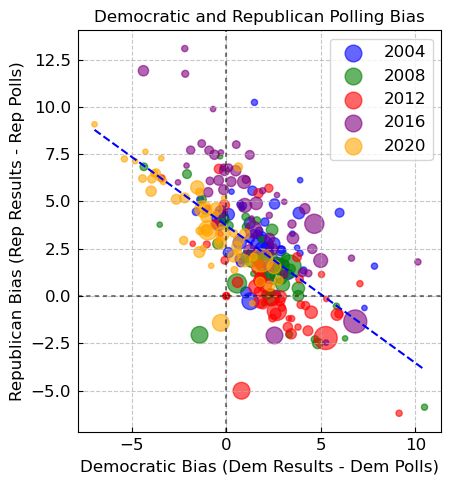

In [155]:
plot_bias_comparison(final_df2)
plt.savefig('./plots/all_historical_biases.png',bbox_inches='tight')

In [188]:
def plot_rep_results_vs_poll_difference(df,plot_rep_result=True):
    # Get unique cycles
    cycles = sorted(df['cycle'].unique())
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Define colors for each cycle
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    all_poll_diff = []
    all_results = []
    
    for i, cycle in enumerate(cycles):
        cycle_data = df[df['cycle'] == cycle]
        
        # Get Democratic and Republican data
        dem_data = cycle_data[cycle_data['party'] == 'DEM']
        rep_data = cycle_data[cycle_data['party'] == 'REP']
        
        # Merge Democratic and Republican data
        merged_data = pd.merge(dem_data, rep_data, on=['cycle', 'state', 'Electors'], suffixes=('_dem', '_rep'))
        
        # Calculate the difference between Rep and Dem polls
        
        if plot_rep_result:
            y = merged_data['result_pct_rep']
            ylabel = 'Republican Results (%)'
            xlabel = 'Rep Polls - Dem Polls (%)'
            poll_difference = merged_data['poll_pct_rep'] - merged_data['poll_pct_dem']
        
        else:
            y = merged_data['result_pct_dem']
            ylabel = 'Democratic Results (%)'
            xlabel = 'Dem Polls - Rep Polls (%)'
            poll_difference = merged_data['poll_pct_dem'] - merged_data['poll_pct_rep']
        
        # Plot the scatter
        scatter = ax.scatter(poll_difference, y, 
                             alpha=0.6, s=merged_data['Electors']*5, 
                             label=str(cycle), color=colors[i % len(colors)])
        
        all_poll_diff.extend(poll_difference)
        
        if plot_rep_result:
            all_results.extend(merged_data['result_pct_rep'])
        else:
            all_results.extend(merged_data['result_pct_dem'])
        
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(all_poll_diff, all_results)
    print(slope, intercept)
    # Create line of best fit
    line_x = np.array([min(all_poll_diff), max(all_poll_diff)])
    line_y = slope * line_x + intercept
    
    # Plot the regression line
    ax.plot(line_x, line_y, color='black', linestyle='--')
    
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #ax.set_title('Republican Results vs Difference between Rep and Dem Polls')
    
    # Add diagonal line at y = x + 50
    lims = [
        max(min(all_poll_diff), -50),  # min of x-axis or -50
        min(max(all_poll_diff), 50),   # max of x-axis or 50
    ]

    # Set axis limits
    ax.set_xlim(lims)
    ax.set_ylim(20, 85)
    
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()

0.5638400938929439 49.33074169899948


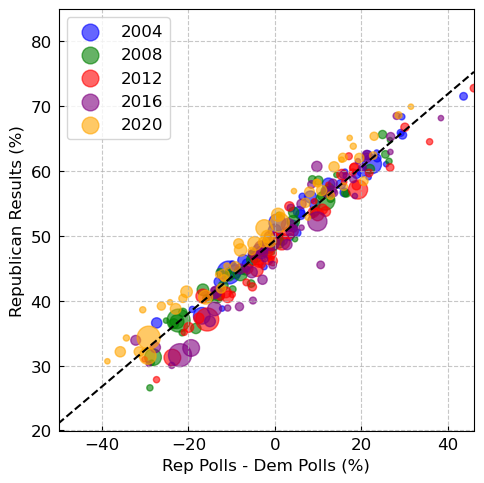

In [189]:
plot_rep_results_vs_poll_difference(final_df2)
plt.savefig('./plots/rep_results_poll_diff.png',bbox_inches='tight')

0.5566937397981057 47.83264454426927


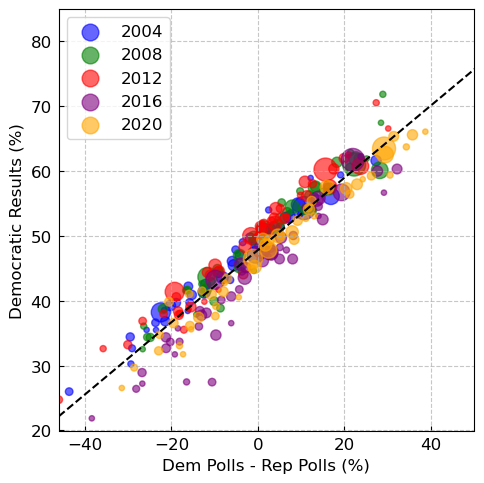

In [191]:
plot_rep_results_vs_poll_difference(final_df2, plot_rep_result=False)
plt.savefig('./plots/dem_results_poll_diff.png',bbox_inches='tight')

In [196]:
def plot_result_difference_vs_poll_difference(df):
    # Get unique cycles
    cycles = sorted(df['cycle'].unique())
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Define colors for each cycle
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    all_poll_diff = []
    all_result_diff = []
    
    for i, cycle in enumerate(cycles):
        cycle_data = df[df['cycle'] == cycle]
        
        # Get Democratic and Republican data
        dem_data = cycle_data[cycle_data['party'] == 'DEM']
        rep_data = cycle_data[cycle_data['party'] == 'REP']
        
        # Merge Democratic and Republican data
        merged_data = pd.merge(dem_data, rep_data, on=['cycle', 'state', 'Electors'], suffixes=('_dem', '_rep'))
        
        # Calculate the difference between Rep and Dem polls and results
        poll_difference = merged_data['poll_pct_rep'] - merged_data['poll_pct_dem']
        result_difference = merged_data['result_pct_rep'] - merged_data['result_pct_dem']
        
        # Plot the scatter
        scatter = ax.scatter(poll_difference, result_difference, 
                             alpha=0.6, s=merged_data['Electors']*5, 
                             label=str(cycle), color=colors[i % len(colors)])
        
        all_poll_diff.extend(poll_difference)
        all_result_diff.extend(result_difference)
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(all_poll_diff, all_result_diff)
    print(f"Slope: {slope}, Intercept: {intercept}, R-value: {r_value}")
    
    # Create line of best fit
    line_x = np.array([min(all_poll_diff), max(all_poll_diff)])
    line_y = slope * line_x + intercept
    
    # Plot the regression line
    ax.plot(line_x, line_y, color='black', linestyle='--')
    
    # Set labels and title
    ax.set_xlabel('Poll Difference (Rep - Dem) (%)')
    ax.set_ylabel('Result Difference (Rep - Dem) (%)')
    ax.set_title('Result Difference vs Poll Difference')
    
    # Add diagonal line at y = x
    lims = [
        max(min(all_poll_diff + all_result_diff), -100),  # min of both axes or -100
        min(max(all_poll_diff + all_result_diff), 100),   # max of both axes or 100
    ]
    #ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
    
    # Set axis limits
    ax.set_xlim(-40,50)
    ax.set_ylim(-40,50)
    
    # Add legend
    ax.legend()
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()

Slope: 1.120533833691049, Intercept: 1.498097154730207, R-value: 0.9773774729459913


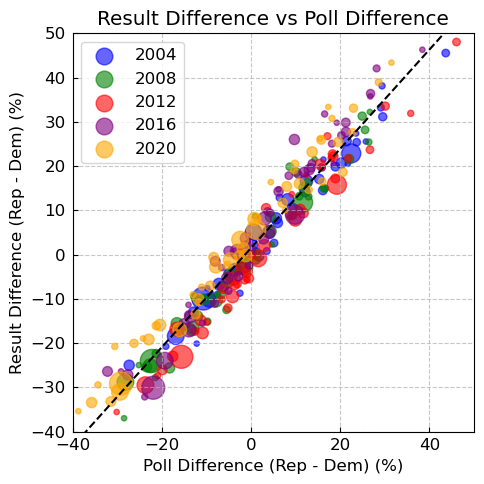

In [197]:
plot_result_difference_vs_poll_difference(final_df2)

In [200]:

def plot_bias_histograms(df):
    # Filter the dataframe for each party
    dem_df = df[df['party'] == 'DEM']
    rep_df = df[df['party'] == 'REP']

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Set the number of bins and range
    bins = np.linspace(-20, 20, 41)  # Adjust the range and number of bins as needed

    # Plot Democratic bias histogram
    ax.hist(dem_df['bias'], bins=bins, alpha=0.6, color='blue', label='Democratic')

    # Plot Republican bias histogram
    ax.hist(rep_df['bias'], bins=bins, alpha=0.6, color='red', label='Republican')

    # Add vertical line at x=0 for reference
    ax.axvline(x=0, color='black', linestyle='--', alpha=0.7)

    # Set title and labels
    ax.set_title('Bias Distributions for Democratic and Republican Parties', fontsize=16)
    ax.set_xlabel('Bias', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    
    # Add legend
    ax.legend(fontsize=10)
    ax.set_xlim(-20,20)
    # Adjust layout and display the plot
    plt.tight_layout()

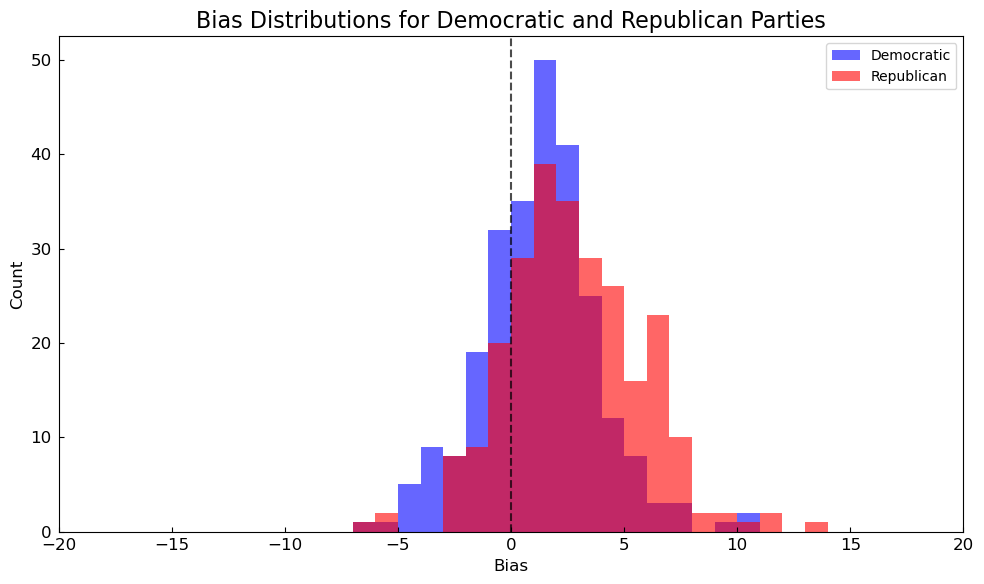

In [201]:
plot_bias_histograms(final_df2)

In [212]:
def plot_bias_boxplots(df):
    # Get unique cycles
    cycles = sorted(df['cycle'].unique())

    # Create separate plots for Democratic and Republican biases
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    
    for party, ax in zip(['DEM', 'REP'], [ax1, ax2]):
        # Filter data for the current party
        party_data = df[df['party'] == party]
        
        # Create box plot
        bp = ax.boxplot([party_data[party_data['cycle'] == cycle]['bias'] for cycle in cycles],
                        labels=cycles, patch_artist=True)
        
        # Color the boxes
        for box in bp['boxes']:
            box.set(facecolor='lightblue' if party == 'DEM' else 'lightcoral')
        
        # Set title and labels
        ax.set_title(f'{party} Bias Distribution by Election Cycle', fontsize=16)
        ax.set_xlabel('Election Cycle', fontsize=12)
        ax.set_ylabel('Bias', fontsize=12)
        
        # Rotate x-axis labels for better readability
        ax.set_xticklabels(cycles, rotation=45)
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.7)

    plt.tight_layout()

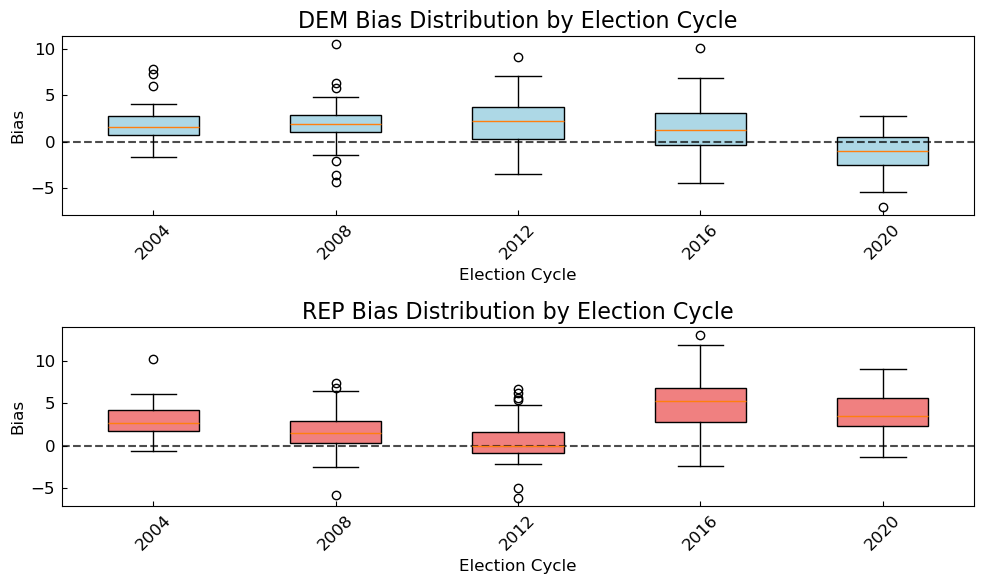

In [214]:
plot_bias_boxplots(final_df2)
plt.savefig('./plots/bias_progression.png',bbox_inches='tight')